# Домашнее задание 2

Выполните следующие задания. Полученный после заполнения вашим кодом файл присылайте на почту kurnosovartem@gmail.com, следуя тем же правилам, что в первом задании.

In [1]:
import networkx as nx

### Задание 1
Построив соответствующую сеть и решив для неё задачу о максимальном потоке любым из [имеющихся в networkx алгоритмов](https://networkx.org/documentation/stable/reference/algorithms/flow.html), найдите паросочетание максимального размера в заданном неориентированном двудольном графе $G$ ниже. Убедитесь, что Ваш код проходит тест ниже.

In [2]:
k = 5
n = 20
G = nx.Graph()
G.add_nodes_from(range(2*n))
G.add_edges_from(
    [(a, b + n) for a,b in nx.random_regular_graph(k, n, 2020).edges()],
    capacity=1.0
)
# Построенный выше тестовый граф G — двудольный
# с номерами вершин в одной доле от 0 до n-1
# и в другой доле от n до 2*n-1

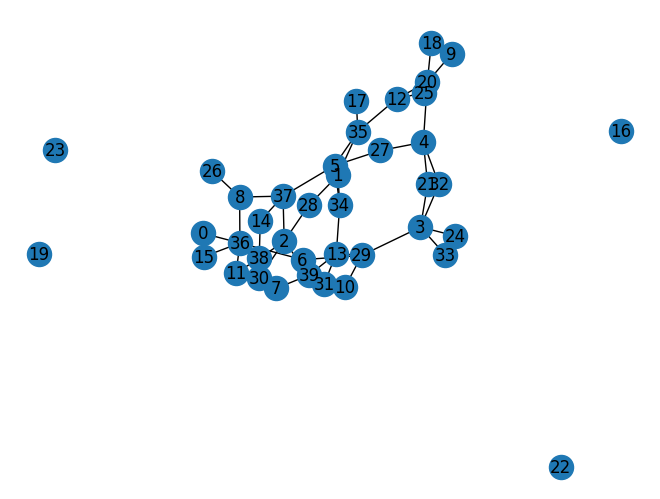

In [3]:
nx.draw(G, with_labels=True)

In [4]:
B = nx.DiGraph()
B.add_nodes_from(range(2*n))
B.add_edges_from(
    [(a, b + n) for a,b in nx.random_regular_graph(k, n, 2020).edges()],
    capacity=1.0
)
B.add_nodes_from([40, 41])
for i in G.nodes():
    if i < n:
        B.add_edge(
            40, i, capacity=1.0
        )
    elif i >= n:
        B.add_edge(
            i, 41, capacity=1.0
        )

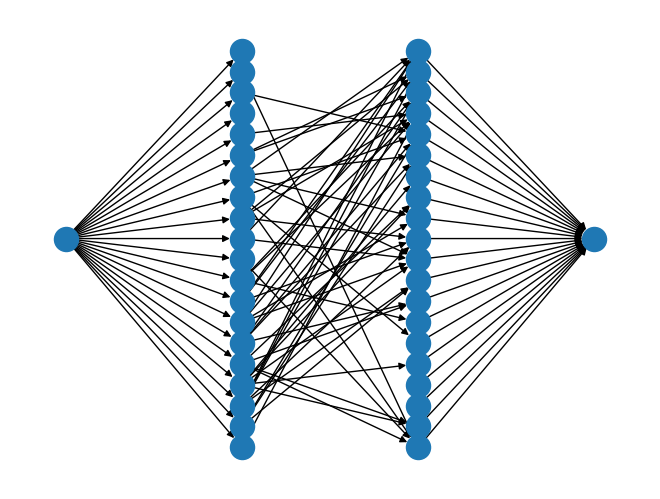

In [5]:
import matplotlib.pyplot as plt

X, Y = nx.bipartite.sets(B)
pos = dict()
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( [(40, (0, 10))])
pos.update( [(41, (3, 10))])
nx.draw(B, pos=pos)
plt.show()

In [6]:
value, fdict = nx.maximum_flow(B, 40, 41)

In [7]:
value

16.0

In [8]:
# В переменную M сохраните множество рёбер
# наибольшего паросочетания в графе G
# Ребро — это tuple или set или frozenset,
# содержащее соответствующую пару вершин
# Ваш код тут.
M = set((u, v) for u, neighbors in fdict.items() if u not in [40, 41]
     for v in neighbors if neighbors[v] == 1 and v not in [40, 41])

In [9]:
# Это простая проверка того, что M образует паросочетание,
# и что его размер совпадает с эталонным
from functools import reduce
print(1 == len({
    2*len(M),
    len(reduce(lambda e1, e2: set(e1) | set(e2), M)),
    len(nx.bipartite.maximum_matching(G, range(n)))
}))

True


### Задание 2
Построив соответствующую сеть и решив для неё задачу о максимальном потоке, найдите максимально возможное количество не пересекающихся по внутренним **вершинам** путей между вершинами $s$ и $t$ в заданном неориентированном графе $G$. Убедитесь, что Ваш код проходит тест ниже.

In [10]:
def num_disjoint_paths(G, s, t):
    # Ваш код тут.
    g = nx.Graph()
    for u, v in G.edges():
        if u in [s, t] or v in [s, t]:
            g.add_edge(u, v, capacity=1)
            continue
        new_vertex = f'_{v}'
        g.add_edge(u, new_vertex, capacity=1)
        g.add_edge(new_vertex, v, capacity=1)

    max_flow_value = nx.maximum_flow_value(g, s, t)

    return max_flow_value

In [11]:
# Простой тест, он должен проходиться при запуске непосредственно после предыдущей ячейки
G = nx.mycielski_graph(10)
s = 7
t = 700
print(
    num_disjoint_paths(G, s, t)
    ==
    nx.node_connectivity(G, s, t)
)

True


### Задание 3
Построив поток в соответствующей сети, выберите из данного множества задач `tasks` такое подмножество, суммарная выгода выполнения задач которого максимальна.

Словарь `prerequisites` содержит для каждой задачи перечень других задач, которые требуется решить перед началом её выполнения (если таковые есть).

Словарь `profit` содержит информацию о выгоде решения каждой из задач. Выгоды — целочисленные, могут быть как положительные, так и отрицательные, и нулевые.

Также задано множество `compulsory` задач, которые нужно решить в обязательном порядке. Подумайте, и опишите в комментириях, как с минимальными усилиями интегрировать это в рассказанный на лекции алгоритм. Убедитесь, что Ваш код проходит тест ниже.

In [12]:
# Ниже приведён алгоритм решения задачи полным перебором,
# результат работы которого можно считать эталонным
from itertools import combinations

def brute_force_selection(tasks, prerequisites, profit, compulsory):
    best_profit = 0
    best_selection = set()
    for ss in range(1, len(tasks)):
        for c in combinations(tasks, ss):
            if any(t not in c for t in compulsory):
                continue
            for t in c:
                if t in prerequisites:
                    for p in prerequisites[t]:
                        if p not in c:
                            break
                    else:
                        continue
                    break
            else:
                current_profit = sum(profit[t] for t in c)
                if current_profit > best_profit:
                    best_profit = current_profit
                    best_selection = set(c)
    return best_selection

In [13]:
def flow_based_selection(tasks, prerequisites, profit, compulsory):
    # Ваш код тут.
    G = nx.DiGraph()
    G.add_nodes_from([p for p in tasks])
    G.add_nodes_from(['s', 't'])
    G.add_edges_from([(v, list(prerequisites[v])[i]) for v in prerequisites.keys() \
                      for i in range(len(prerequisites[v]))])

    for v in tasks:
        if v in compulsory:
            G.add_edge('s', v, capacity=1000)
        else:
            if profit[v] > 0:
                G.add_edge('s', v, capacity=profit[v])
            if profit[v] < 0:
                G.add_edge(v, 't', capacity=-profit[v])


    cut_value, partition = nx.minimum_cut(G, 's', 't')
    best_selection = partition[0]
    best_selection.remove('s')

    return best_selection

In [14]:
# Простой тест, он должен проходиться при запуске непосредственно после выполнения предыдущей ячейки
import random
random.seed(2022)

tasks = set(range(1, 22))

ranges = [
    (1, len(tasks) // 3),
    (len(tasks) // 3, 2 * len(tasks) // 3),
    (2 * len(tasks) // 3, len(tasks))
]

prerequisites = {}
for ri, r in enumerate(ranges):
    if ri == 0:
        continue
    for t in range(*r):
        if random.randrange(1000)/1000 < 0.4:
            prerequisites[t] = set(random.sample(range(*ranges[ri-1]), 4))

profit = {
    task: random.randrange(-7, 15)
    for task in tasks
}

compulsory = set(random.sample(tasks, 2))

print(1 == len(set(
    sum(map(profit.get,
        method(
            tasks,
            prerequisites,
            profit,
            compulsory
        )
    ))
    for method in [
        brute_force_selection,
        flow_based_selection
    ]
)))

<ipython-input-14-b95f3a9067ab>:26: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  compulsory = set(random.sample(tasks, 2))


True
